# Different categories of RNN models:

 - Many-to-one (sentiment analysis, fake news detection)
 - many-to-many (i.e. seq2seq, machine translation, text summary)
 - one-to-many (image captioning), one-to-one (plain MLP networks)
 

We previously looked at a many-to-one model for a sentiment analysis task (the IMDB dataset), and now let's dive into a more complicated type of RNN: many-to-many, i.e. seq2seq.

# Import packages and download data

Dataset introduction: 

This [dataset](https://www.manythings.org/anki/) consists of many combinations of bilingual sentence pairs. The lengths of the sentences and the vocabulary sizes are relatively small. In this notebook, we choose the subset of English-French sentence pairs. 

Main steps of notebook include:
 - Preprocess raw text data (regex data cleaning, deciding max lengths, tokenizer training)
 - Model setup for training (using keras functional API instead of sequential API)
 - Model setup for predictions



In [1]:
import pathlib
import random
import string
import re
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import time
import os 

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(940)

In [68]:
# download and extract text data
text_file = keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)

# location of downloaded data
print('location of downloaded data: ',text_file)

# change data path to a pathlib object for parsing
text_file = pathlib.Path(text_file).parent / "fra.txt"

location of downloaded data:  /root/.keras/datasets/fra-eng.zip


# Preprocess raw text data

In this section, we will perform standard text preprocessing such as lowercasing characters, removing miscellaneous symbols, standardize whitespace symbols. A majority of the work is done using the regular expression library of python. Then we will train a tokenizer from scratch.  

### RegEx preprocessing

In [69]:
with open(text_file,'r',encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]

# list for storing parsed data
text_pairs = []

for line in lines:
    # split source & target sentence
    eng, fra = line.split("\t")

    # store the parsed datapoint
    text_pairs.append((eng,fra))

del lines

In [70]:
import unicodedata

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(s,verbose=False):
    if verbose:
        print(s)

    # convert characters to lowercase
    # convert characters to ascii for regex preprocessing
    s = unicode_to_ascii(s.lower())
    if verbose:
        print(s)

    # Remove the characters - <>()|&©ø"',;?~*!
    s = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", r" ", s)
    if verbose:
        print(s)

    # remove punctuations at the end of a word
    s = re.sub("(\.\s+)", r" ", s)
    s = re.sub("(\-\s+)", r" ", s)
    s = re.sub("(\:\s+)", r" ", s)
    s = re.sub("(\!\s+)", r" ", s)
    if verbose:
        print(s)

    # remove other characters that are not letters 
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    if verbose:
        print(s)

    # remove multiple whitespaces
    s = re.sub(r'(\s+)', r' ', s)
    if verbose:
        print(s)

    # Remove the single character hanging between any two spaces
    s = re.sub("(\s+.\s+)", r" ", s)
    if verbose:
        print(s)

    # removes whitespaces in the beginning and the end
    s = s.strip()
    if verbose:
        print(s)

    # add start and end of sentence tokens
    s = '<start>' +' '+ s +' '+'<end>'
    return s

s = '  1234 reguLAR eXpreSSion sooo\t hard!!! - <>()|&©ø"\',;?~*   '
preprocess_sentence(s,verbose=True)

  1234 reguLAR eXpreSSion sooo	 hard!!! - <>()|&©ø"',;?~*   
  1234 regular expression sooo	 hard!!! - <>()|&©ø"',;?~*   
  1234 regular expression sooo	 hard    -                   
  1234 regular expression sooo	 hard     
 regular expression sooo hard 
 regular expression sooo hard 
 regular expression sooo hard 
regular expression sooo hard


'<start> regular expression sooo hard <end>'

Clean raw text using regex

In [71]:
#text_pairs = text_pairs[:5000]

# lists to store preprocessed text
lang_eng = []
lang_fra = []

# separate english and french text
raw_data_eng, raw_data_fra = list(zip(*text_pairs))
raw_data_eng, raw_data_fra = list(raw_data_eng), list(raw_data_fra)

# preprocess english and french raw text
for i, j in zip(raw_data_eng, raw_data_fra):
    preprocessed_data_eng = preprocess_sentence(i)
    preprocessed_data_fra = preprocess_sentence(j)
    lang_eng.append(preprocessed_data_eng)
    lang_fra.append(preprocessed_data_fra)

del raw_data_eng; del raw_data_fra;
# del text_pairs; 

In [72]:
lang_eng[0:5]

['<start> go. <end>',
 '<start> hi. <end>',
 '<start> run <end>',
 '<start> run <end>',
 '<start> who <end>']

In [73]:
lang_fra[0:5]

['<start> va <end>',
 '<start> salut <end>',
 '<start> cours <end>',
 '<start> courez <end>',
 '<start> qui <end>']

### Select sentences that are shorter than the maximum lengths allowed

In a large dataset, it is possible that a very few sentences are very lengthy, while the remaining majority are much shorter. In this case, if we keep those lengthy sentences, then we need to zero pad the remaining ones up to the same length, which requires the machine to store a lot of zeros for nothing. To avoid this, we simply look at the distribution of lengths for both languages, and regulate the max lengths. 

In [8]:
# count lengths of sentences in english and french
eng_lengths = np.array([len(sentence.split()) for sentence in lang_eng])
fra_lengths = np.array([len(sentence.split()) for sentence in lang_fra])

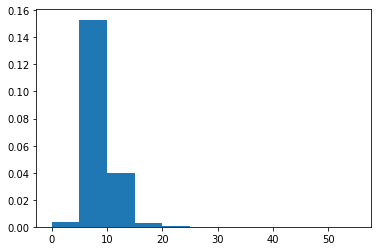

In [9]:
plt.hist(eng_lengths,bins=np.arange(0,60,5),density=True);

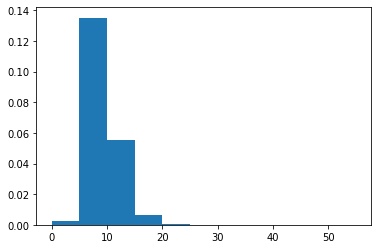

In [10]:
plt.hist(fra_lengths,bins=np.arange(0,60,5),density=True);

After looking at the histograms, we can restrict the length of English sentences to 20, and the length of French sentences to 20

In [11]:
# hard coded max lengths
max_length_targ, max_length_inp = 20,20

# put two lists into a df to select pairs
cleaned_text = pd.DataFrame({'eng_cleaned':lang_eng,'fra_cleaned':lang_fra})

# condition of a pair getting selected
def select_sentence_pair(row):
    # selected if both sentences are shorter than the max lengths
    if len(row.iloc[0].split()) < max_length_inp and len(row.iloc[1].split()) < max_length_targ:
        return 1
    else:
        return 0

keep = cleaned_text.apply(select_sentence_pair,axis=1)
cleaned_text['keep'] = keep

# filter out unwanted data 
cleaned_text = cleaned_text[cleaned_text.keep == 1]

lang_eng = cleaned_text.iloc[:,0].tolist()
lang_fra = cleaned_text.iloc[:,1].tolist()

del cleaned_text

###  Detect empty sentences

If any empty sentence detected in a pair, then we will delete that pair from the data.

In [79]:
# detect if there are any empty sentences,i.e, which only have '<start>' and '<end>' tokens
ind = []

# for each sentence in the corpus
for i in range(len(lang_eng)):
    
    for j in lang_eng[i].split():
        if j == '<start>':
            empty = True
        elif j == '<end>' and empty:
            ind.append(i)
            print('empty English sentence detected! index:',i)
        else: 
            empty = False
    
print('# of empty English sentences:', len(ind))

ind = []

# for each sentence in the corpus
for i in range(len(lang_fra)):
    
    for j in lang_fra[i].split():
        if j == '<start>':
            empty = True
        elif j == '<end>' and empty:
            ind.append(i)
            print('empty French sentence detected! index:',i)
        else: 
            empty = False
    
print('# of empty French sentences:', len(ind))

# of empty English sentences: 0
# of empty French sentences: 0


### Split training and test datasets

In [13]:
from sklearn.model_selection import train_test_split

# Creating training and validation sets using an 80-20 split
lang_eng_tr, lang_eng_val, lang_fra_tr, lang_fra_val \
= train_test_split(np.array(lang_eng),np.array(lang_fra),test_size=0.1,shuffle=True,
                   random_state=940)

# Show length
print('training size: %d, test size: %d\n' % (len(lang_eng_tr), len(lang_eng_val)))

training size: 149788, test size: 16644



In [14]:
del lang_eng; del lang_fra

### Tokenizer training 

The tokenizers of English and French are trained on the training dataset. But here we'll trian the tokenizers twice. After training them the first time, we determine the number of rare words in each vocabulary and remove the rare words for the second training. Finally, the tokenizers from the second training will be kept.

In [15]:
# train simple tokenizers (1st time)
# here we don't need the transformed sequences of integers, we just need to check 
# vocab sizes inside the tokenizer objects

def tokenize(lang,vocab_size=None):
    if vocab_size is not None:
        print('restricted vocab size training')
        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='',num_words=vocab_size)
    else:
        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')

    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    # shape of tensor: Number of examples x Max length of sentence
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post')
    print('tokenizer trained!')
    return tensor, lang_tokenizer

# input language is english
_, inp_tokenizer = tokenize(lang_eng_tr)

# target language is french
_, targ_tokenizer = tokenize(lang_fra_tr)

tokenizer trained!
tokenizer trained!


In [16]:
# if a word occurs fewer than 5 times in the english corpus, exclude it
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in inp_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

eng_vocab_size = tot_cnt - cnt + 1
print("final vocab size of English: ", eng_vocab_size)

% of rare words in vocabulary:  61.63721329967235
final vocab size of English:  7143


In [17]:
# if a word occurs fewer than 5 times in the french corpus, exclude it
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in targ_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

fra_vocab_size = tot_cnt - cnt + 1
print("final vocab size of French: ", fra_vocab_size)

% of rare words in vocabulary:  68.36314546068174
final vocab size of French:  9375


In [87]:
# train simple tokenizers (2nd time)
# here we retrain tokenizers with restrictions on vocab sizes
# and get the tokenized tensors

input_tensor, inp_tokenizer = tokenize(lang_eng_tr,vocab_size=eng_vocab_size)

target_tensor, targ_tokenizer = tokenize(lang_fra_tr,vocab_size=fra_vocab_size)

restricted vocab size training
tokenizer trained!
restricted vocab size training
tokenizer trained!


In [19]:
# demo of word & index mapping of the tokenizers
def convert(tokenizer, tensor):
    for t in tensor:
        if t != 0:
            print ("%d ----> %s" % (t, tokenizer.index_word[t]))

print("Input Language; index to word mapping")
convert(inp_tokenizer, input_tensor[0])
print()
print("Target Language; index to word mapping")
convert(targ_tokenizer, target_tensor[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> you
23 ----> are
84 ----> good
735 ----> person.
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
142 ----> t
59 ----> es
15 ----> un
3228 ----> chic
2015 ----> type.
2 ----> <end>


Now, we need to check again the length of each tokenized sequence in both languages. Note that this could be different from the max length of setences that we just regulated.

In [20]:
# find out the number of tokens in a sequence
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [21]:
max_length_targ

19

In [22]:
max_length_inp

19

In [26]:
# vocab sizes for two langauges
vocab_inp_size = inp_tokenizer.num_words
vocab_tar_size = targ_tokenizer.num_words

# Encoder-decoder model using LSTM

For building the model, we will see how to use the functional API of Keras instead of the sequential API that we used in CNN Keras tutorial. The functional API gives more flexibility, allowing us to build more complex models such as seq2seq models and models with skip connections.

Here we are going to use **teacher forcing** for training, which means the correct token of the target language is passed into the decoder, and then the decoder predicts the next token. If without teacher forcing, the previously decoder-predicted token is passed into the decoder as the current step input.

### Build model

In [43]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
HIDDEN_DIM = 256
EMBED_DIM = 256

# Encoder
encoder_inputs = Input(shape=(max_length_inp, ))

# Embedding layer
enc_emb = Embedding(vocab_inp_size, EMBED_DIM,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(HIDDEN_DIM, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(HIDDEN_DIM, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(HIDDEN_DIM, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state

# input layer for target sequences
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(vocab_tar_size, EMBED_DIM, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(HIDDEN_DIM, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(vocab_tar_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 19)]         0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 19, 256)      1828608     ['input_10[0][0]']               
                                                                                                  
 lstm_18 (LSTM)                 [(None, 19, 256),    525312      ['embedding_9[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4,clipvalue=1.0), 
              # adam optimizer with gradient clipping

              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  
              # sparse categorical crossentropy is the same as cat crossentropy
              # but it expects labels to be integers, not one-hot vectors
              # accelerates training compared to the original cat crossentropy 

              metrics=['accuracy'])

# early stopping by monitoring validation loss
# if validation loss didn't decrease in the past two epochs, stop training
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

### Train model

In [45]:
# the labels for loss calculation are also the target tensor, but offset forward by 1 

EPOCHS = 50
BATCH_SIZE = 128 

model.fit(x=[input_tensor, target_tensor[:,:-1]], 
          y=target_tensor.reshape(target_tensor.shape[0],target_tensor.shape[1],1)[:,1:],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[es],
          validation_split=0.1)

Epoch 1/50
1054/1054 [==============================] - 502s 469ms/step - loss: 2.3995 - accuracy: 0.6552 - val_loss: 2.0161 - val_accuracy: 0.6869
Epoch 2/50
1054/1054 [==============================] - 424s 402ms/step - loss: 1.8373 - accuracy: 0.7070 - val_loss: 1.6905 - val_accuracy: 0.7226
Epoch 3/50
1054/1054 [==============================] - 361s 342ms/step - loss: 1.5842 - accuracy: 0.7320 - val_loss: 1.5023 - val_accuracy: 0.7398
Epoch 4/50
1054/1054 [==============================] - 359s 340ms/step - loss: 1.4278 - accuracy: 0.7465 - val_loss: 1.3786 - val_accuracy: 0.7527
Epoch 5/50
1054/1054 [==============================] - 356s 338ms/step - loss: 1.3140 - accuracy: 0.7585 - val_loss: 1.2847 - val_accuracy: 0.7639
Epoch 6/50
1054/1054 [==============================] - 355s 337ms/step - loss: 1.2239 - accuracy: 0.7684 - val_loss: 1.2117 - val_accuracy: 0.7724
Epoch 7/50
1054/1054 [==============================] - 360s 341ms/step - loss: 1.1468 - accuracy: 0.7772 - val_

Early stopping was triggered right at the final epoch. 

### Save checkpoint

In [46]:
model.save('./lstm_seq2seq.h5')

# Predictions


### Prediction setup



Here a lot more code is typed compared to the prediction step of a CNN model, or an RNN model for sentiment analysis, because now we are in a sequence-to-sequence task, and the encoder-decoder behaves differently in training and in prediction mode. 

To be specific, since we used teacher forcing when we trained this encoder-decoder, and we don't have the target sequences available (supposedly) when predicting on the test data, we need to modify the model to make sure it behaves correctly.

In [84]:
# create another instance of encoder model 
encoder_model = Model(encoder_inputs, [encoder_outputs,state_h,state_c])

# create another instance of decoder model, with hidden states as inputs too

# make additional input layers so that the decoder takes in encoder states
decoder_state_input_h = Input(shape=(HIDDEN_DIM,))
decoder_state_input_c = Input(shape=(HIDDEN_DIM,))
decoder_hidden_state_input = Input(shape=(max_length_inp, HIDDEN_DIM))

# same embedding layer for the decoder 
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

Now we code a function that calls the model to translate one English sentence to French (for simplicity). You can also batch up the prediction process, but you might need to change the axis of `np.argmax` in the token sampling step.

In [85]:
def decode_sequence(input_seq):
    '''translates one sequence in input language to sequence in output language'''
    
    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = targ_tokenizer.word_index['<start>']

    stop_condition = False
    decoded_sentence = ''

    word_count = 0
    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = targ_tokenizer.index_word[sampled_token_index]

        word_count += 1

        if sampled_token != '<end>':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == '<end>' or word_count \
            > max_length_targ :
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

# To convert sequence to english
def seq2eng(seq):
    newString = ''
    for i in seq:
        if i != 0 and i != inp_tokenizer.word_index['<start>'] and i \
            != inp_tokenizer.word_index['<end>']:
            newString = newString + inp_tokenizer.index_word[i] + ' '

    return newString

# To convert sequence to french
def seq2fra(seq):
    newString = ''
    for i in seq:
        if i != 0 and i != targ_tokenizer.word_index['<start>'] and i \
            != targ_tokenizer.word_index['<end>']:
            newString = newString + targ_tokenizer.index_word[i] + ' '

    return newString

### Predictions on the training set

In [88]:
for i in range(0, 10):
    print('English:', seq2eng(input_tensor[i]))
    print('Original French:', seq2fra(target_tensor[i]))
    print('Predicted French:', decode_sequence(input_tensor[i].reshape(1,  # add one more axis upfront, because our model only takes in tensor with 3 axes, the first one storing different datapoints 
           max_length_inp)))
    print('\n')

English: you are good person. 
Original French: t es un chic type. 
Predicted French:  vous etes une bonne personne.


English: he was real 
Original French: c etait un vrai 
Predicted French:  il etait vraiment timide.


English: they slept in the same bed. 
Original French: elles ont dormi dans le meme lit. 
Predicted French:  elles ont dormi dans le meme lit.


English: i ll forgive you. 
Original French: je vous pardonnerai. 
Predicted French:  je vous pardonnerai.


English: life make vivid on the sensitive plate of his mind. 
Original French: les experiences de la vie des traces sur la sensible de son esprit. 
Predicted French:  la sante sur la societe dans une mauvaise direction.


English: you must be very hungry now. 
Original French: tu dois maintenant avoir tres faim. 
Predicted French:  tu dois etre tres faim maintenant.


English: i left my umbrella in the cab. 
Original French: j ai laisse mon parapluie dans le taxi. 
Predicted French:  j ai laisse mon parapluie dans le t

### Predictions on the test set

In [89]:
def test_tokenize(lang,tokenizer):
    tensor = tokenizer.texts_to_sequences(lang)

    # shape of tensor: Number of examples x Max length of sentence
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                          padding='post')
    print('test data tokenized!')
    return tensor

# tokenize test data
input_tensor = test_tokenize(lang_eng_val,inp_tokenizer)
target_tensor = test_tokenize(lang_fra_val,targ_tokenizer)

test data tokenized!
test data tokenized!


In [90]:
for i in range(0, 10):
    print('English:', seq2eng(input_tensor[i]))
    print('Original French:', seq2fra(target_tensor[i]))
    print('Predicted French:', decode_sequence(input_tensor[i].reshape(1,  # add one more axis upfront, because our model only takes in tensor with 3 axes, the first one storing different datapoints 
           max_length_inp)))
    print('\n')

English: she turned the slowly. 
Original French: elle tourna lentement la poignee de porte. 
Predicted French:  elle eteignit lentement.


English: i sorry didn recognize you. 
Original French: je suis desolee je ne ai pas reconnue. 
Predicted French:  je suis desole je ne vous ai pas reconnue.


English: tom is wearing 
Original French: tom porte des 
Predicted French:  tom porte des lunettes de


English: i hope this won happen again. 
Original French: j espere que ceci arrivera plus. 
Predicted French:  j espere que ca ne va pas arriver.


English: you need to save the princess. 
Original French: il vous faut sauver la princesse. 
Predicted French:  il faut que tu la princesse.


English: she ran outside half naked. 
Original French: elle couru dehors moitie nue. 
Predicted French:  elle courut dehors moitie nue.


English: everything is broken. 
Original French: tout est brise. 
Predicted French:  tout est casse.


English: long story short was fired. 
Original French: en ai ete v

References:

https://blog.paperspace.com/introduction-to-seq2seq-models/; 

https://blog.paperspace.com/implement-seq2seq-for-text-summarization-keras/